# Getting started

The package `h5wrapper` provides wrapper-classes built upon and around the main classes of the `h5py` package. It acts like an interface between an HDF5 file and the user by supervising data writing and reading based on certain so-called conventions and layouts.

There are multiple wrapper-classes implemented, each of which exteding functionality and introducing specific layout- and naming-convetions.
The basic wrapper-class is called `H5File`. We will first demonstrate the functionalities and concepts around it before the more specialize wrapper classes are shown.

This notebook walks you through the fundamental concept using the basic wrapper calss `H5File` built around the `h5py.File` class. It extends `h5py.File`, `h5py.Dataset` and `h5px.Group` with some useful functionality motivated by sustainable datamanagement and onerous processing of data stored in an HDF5 file.

The wrapper classes extend but don't limit the funcitonality of the `h5py` package, so everything knwon from it is available also through this package. An HDF created, read or generally processed with `H5File` requires to respect certain conventions and prinicples. It is possible to ignore them but warnings will be raised. The following sections walk you through the concept and basic functionalities of the first warpper-class `H5File`:

In [1]:
from h5rdmtoolbox.h5wrapper import H5File

c:\users\da4323\documents\programming\github\h5rdmtoolbox\h5rdmtoolbox\h5wrapper\h5piv.py:675: SpecialDatasetRegistrationWarning: registration of accessor <class 'h5rdmtoolbox.h5wrapper.h5piv.PIVDisplacementDataset'> under name 'DisplacementVector' for type <class 'h5rdmtoolbox.h5wrapper.h5piv.H5PIVGroup'> is overriding a preexisting attribute with the same name.
  class PIVDisplacementDataset(DisplacementDataset):


## Opening a file
... and displaying (dumping) the content). An interactive html representation of the file content is displayed. At the moment only attributes at the root level exist. They were created when the file was opened in write mode. While `creation_time` and `modification_time` are treated as regular attributes `__h5rdmtoolbox_version__` and `__wrcls__`, thus attribus starting and ending with `__` are special attributes reserved/used by the package.

In [2]:
with H5File() as h5file:  # default mode is 'r+'
    h5file.dump()   # call .sdump() outside of notebooks to get a similar but non-interactive representation

Using `open_wrapper()` opens the file and returns the respective wrapper class instance, namely the one that wrote to the file previously, here `H5File`

In [3]:
from h5rdmtoolbox.h5wrapper import open_wrapper
with open_wrapper(h5file.hdf_filename) as h5:
    h5.dump()
    print('Wrapper class instance name: ', type(h5))

Wrapper class instance name:  <class 'h5rdmtoolbox.h5wrapper.h5file.H5File'>


# Conventions and layout schema:

 - Conventions: Mainly naming conventions
 - Layout (schema): required dataset, data dimension, attributes, groups in an HDF5 file that must always exist


Conventions are generally defined by a community (e.g. concept of standard names is used here: [cfconventions.org]) and regulate the usage of certain names. This repository supports the principle set by the climate and forecast community [cfconventions.org]. This means that each dataset must have one of the following or bth attributes:
  - `standard_name`
  - `long_name`.
  
While `long_name` is a user-defined and user-readable (as opposed to machine-readable) string without restrictions (e.g. w.r.t length), the attribute `standard_name` cannot be chosen freely but is defined by a `convention`. Each wrapper file (excepet the very basic one `H5Base`) is associated with a convention. A convention can be defined by an `XML` file, read in and passed to the wrapper class. For e.g. `H5Flow` the `FluidConvention` is set per default. Here, for instance, a dataset `x` shall be the created using the wrapper class `H5Flow`, then if the `standard_name` is set it is verified in the associated standard name convention.

[cfconventions.org]: http://cfconventions.org/

In [4]:
with H5File(standard_name_table=None) as h5f:
    print(h5f.standard_name_table)

EmptyStandardizedNameTable (version number: None)


The `H5Flow` class has a *non-empty* convention class set per default. Thus when creating datasets and the parameter `stadnard_name`is passed, it is checked if this name exists in the convention. If so, then the units of the created dataset and the registered convention is verified:

In [5]:
from h5rdmtoolbox.h5wrapper import H5Flow
from h5rdmtoolbox.conventions import StandardizedNameError
with H5Flow() as h5f:
    print(h5f.standard_name_table)
    try:
        h5f.create_dataset('x', data=1, standard_name='x coordinate')
    except StandardizedNameError as e:
        print(f' > Incorrect standard name: {e}')
    try:
        h5f.create_dataset('x', data=1, standard_name='x_coordinate', units='kg')
    except StandardizedNameError as e:
        print(f' > Incorrect units: {e}')
    h5f.create_dataset('x', data=1, standard_name='x_coordinate', units='m')
    h5f.dump()

Fluid_Standard_Name (version number: None)
 > Incorrect standard name: Invalid characters in name "x coordinate": Only "_" is allowed.
 > Incorrect units: Unit of standard name "x_coordinate" not as expected: "kg" != "m"


Moreover, a certain **Layout** may be defined along with a wrapper class, e.g. `H5Flow` expecting one-dimensional `x`, `y` and `z` datasets with units `m` and `H5File` expects file to have a `title` as root attribute among other mandatory attributes. They may even be conditional layout restrictions that are considered based on specific user choices.

Let's have a look, how the Layout file of `H5File` and `H5Flow` look like:

In [6]:
H5File.Layout.dump()
print('---')
H5Flow.Layout.dump()

---


---
## File creation
File creation as used to with `h5py` either with or without defining a filename (when passing no (file)name, write intent is automatically set to 'r+'). If no filename is set, a temporary file is created in a tmp-folder. You may also set the attribute `title` by passing it as parameter during initialization:

In [7]:
with H5File('test.hdf', mode='w') as h5:
    h5.dump()
    print(h5.Layout.filename)

C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\layout\H5File.hdf


In [8]:
from pathlib import Path

with H5File() as h5:  # equal to "with H5File(mode='w') as h5:"
    print(f'HDF5 files initialized without any parameters\n--> Mode is {h5.mode} and filename is {h5.filename}')

HDF5 files initialized without any parameters
--> Mode is r+ and filename is C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp94\tmp3.hdf


In [9]:
try:
    print(h5.filenme)
except AttributeError as e:
    print(e)

filenme


In [10]:
print(h5.hdf_filename)

C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp94\tmp3.hdf


## Meta convention: Static layouts:

Each HDF wrapper class must fulfill certain requirements, e.g.
 - to have specific attributes
 - to have specific attributes with a certain value
 - to have specific groups
 - to have specific datasets
 - to have a specific dataset with a specific shape

The base Layout make no specification for datasets or groups except for the root group. It must have certain atributes, such as "CREATION_TIME" or "title". To check which one exactly, let's print the content of the file to the screen using `dump()` (outside of jupyter notebooks print the instance or call `sdump()`)

In [11]:
H5File.Layout.dump()  # alternative: H5File.Layout.sdump()

In [12]:
with H5File.Layout.File as l:
    print(l.attrs.keys())

<KeysViewHDF5 ['__h5rdmtoolbox_version__', 'creation_time', 'modification_time', 'title']>


In [13]:
import h5py
from h5rdmtoolbox.utils import generate_temporary_filename
with h5py.File(generate_temporary_filename(suffix='.hdf'), 'w') as h5:
    h5.attrs['title'] = 'Tutorial data'
    h5.attrs['__version__'] = '0.1.12'
    test_filename = h5.filename  # or h5.hdf_filename

with h5py.File(test_filename) as h5:
    H5File.Layout.check(h5, silent=False)


File layout inspection
------------
inspecting group /
 [gr] /: attribute "creation_time" missing
 [gr] /: attribute "modification_time" missing
 --> 2 issue(s) found during layout inspection


Calling `check()` will perform both dynamic and static check.

In [14]:
with H5File(test_filename) as h5:
    h5.check()


File layout inspection
------------
inspecting group /
 [gr] /: attribute "creation_time" missing
 [gr] /: attribute "modification_time" missing
 --> 2 issue(s) found during layout inspection


---
## Dataset creation
The basic dataset creation is no different than with the `h5py` package. However, `H5File` will encourage you to use an attribute `units` and either `long_name` or `standard_name`. You may pass those parameters in the `create_dataset()` function. If not, you will be warned (which you can suppress in the usual way in python `warnings.filterwarnings("ignore")`) but it has no other consequences. You may also directly specify dimension scales during dataset creation:

First let's create a simple dataset as usual. It will raise a warning, that no long name or standard name has been passed:

In [15]:
import numpy as np
import xarray as xr

In [16]:
with H5File('test.hdf', mode='w', standard_name_table=None) as h5:
    try:
        h5.create_dataset('temperature', data=np.random.rand(3, 2), long_name='temperature of something')
    except ValueError as e:
        print(e)

In [17]:
with H5File('test.hdf', mode='w', standard_name_table=None) as h5:
    h5.create_dataset('temperature', data=np.random.rand(3, 2), long_name='Surface temperature')

In [18]:
with H5File('test.hdf', mode='w', standard_name_table=None) as h5:
    try:
        h5.create_dataset('temperature', data=np.random.rand(3, 2), standard_name='Surface temperature')
    except ValueError as e:
        print(e)

In [19]:
with H5File('test.hdf', mode='w', standard_name_table=None) as h5:
    try:
        h5.create_dataset('temperature', data=np.random.rand(3, 2), standard_name='surface temperature')
    except ValueError as e:
        print(e)

In [20]:
with H5File('test.hdf', mode='w', standard_name_table=None) as h5:
    h5.create_dataset('temperature', data=np.random.rand(3, 2), standard_name='surface_temperature')

Now, let's provide a long_name and a unit, thus no warning will be shown as all requirements are fulfilled. Also note, that we added the parameter `overwrite=True` as we are using the same HDF file and want to overwrite the existing dataset:

In [21]:
with H5File('test.hdf', mode='r+', title='tutorial file') as h5:
    h5.create_dataset('temperature', data=np.random.rand(3, 2),
                     units='degC', overwrite=True, long_name='surface temperature')
    print(h5['temperature'])

H5Dataset "/temperature"
------------------------
shape:         (3, 2)
long_name:     surface temperature
standard_name: None
units:         degC


Even better is to pass a standard name. Then the unit is checked for consistency (e.g. temperature has unit kelvin and not meters)

In [22]:
with H5File('test.hdf', mode='r+', title='tutorial file') as h5:
    try:
        h5.create_dataset('temperature', data=np.random.rand(3, 2),
                          overwrite=True, standard_name='temperature', units='m')
    except Exception as e:
        print(e)

The following temperature dataset has the coorect unit:

In [23]:
with H5File('test.hdf', mode='r+', title='tutorial file') as h5:
    h5.create_dataset('temperature', data=np.random.rand(3, 2),
                     units='degC', overwrite=True, standard_name='temperature')
    print(h5['temperature'])
    print('---')
    h5.sdump()

H5Dataset "/temperature"
------------------------
shape:         (3, 2)
long_name:     None
standard_name: temperature
units:         degC
---
> H5File: Group name: /.

a: __h5rdmtoolbox_version__:      0.1.0
a: __wrcls__:                     H5File
a: creation_time:                 2022-07-28T14:53:45Z+0200
a: modification_time:             2022-07-28T14:53:45Z+0200
a: title:                         tutorial file
temperature            (3, 2)                degC    
	a: standard_name:                 temperature



## Creating datasets and groups from a yaml file

Sometimes it may be useful to write standard datastes and groups to your file (e.g. always the same attributes for repetative tasks). This can be defined in a yaml file:

In [24]:
import yaml

dictionary = {'datasets': {'boundary/outlet/y': {'data': 2, 'units': 'm', 'standard_name': 'y_coordinate',
                                                         'attrs': {'comment': 'test', 'another_attr': 100.2,
                                                                   'array': [1, 2, 3]}}},
                      'groups': {'test/grp': {'long_name': 'a test group'}}
                      }
with open('test.yaml', 'w') as f:
    yaml.safe_dump(dictionary, f)

with H5File('test.hdf', 'w') as h5:
    h5.from_yaml('test.yaml')
    h5.dump()
    
# delete the yaml and hdf file again:
Path('test.yaml').unlink()
h5.hdf_filename.unlink()

---
## Attributes
Attributes can be added to the file as known from `h5py`. During file creation some are automatically created, such as package version and file creation/modification time:

In [25]:
with H5File(mode='w', title='a test file') as h5:
    print(h5.attrs)

__h5rdmtoolbox_version__  0.1.0
__wrcls__                 H5File
creation_time             2022-07-28T14:53:45Z+0200
modification_time         2022-07-28T14:53:45Z+0200
title                     a test file


Besides adding strings or floats as attributes, also **datasets** or **groups** can be **assigned to an attribute**. Effectively the internal HDF path is stored and when the attributed is requested this is recognized and the respective dataset or group is returned:

In [26]:
with H5File(mode='w', title='a test file') as h5:
    grp = h5.create_group('a group')
    h5.attrs['a root group'] = grp
    print(h5.attrs['a root group'])
    grp.create_dataset('ds', units='m/s', data=[1,2,3], standard_name='x_velocity')
    grp.attrs['ref_to_own_ds'] = grp['ds']
    d = h5['a group'].attrs['ref_to_own_ds']
    print(d)

<HDF5 group "/a group" (0 members)>
<HDF5 dataset "ds": shape (3,), type "<i4">


---
## Data exploration and Natural Naming
Besides above stated "rules", the class gives quick and eays insight in the class by using `.print()` or `.explore()` (the fives an interactive HTML representation only available in notbooks).

In [27]:
with H5File(mode='w') as h5:
    print(h5)
    # h5.info()  # equal to print(h5)

> H5File: Group name: /.

a: __h5rdmtoolbox_version__:      0.1.0
a: __wrcls__:                     H5File
a: creation_time:                 2022-07-28T14:53:45Z+0200
a: modification_time:             2022-07-28T14:53:45Z+0200



In [28]:
with H5File(mode='w') as h5:
    h5.dump()

The following raises a warning for not setting `long_name` or `standard_name` and for not defining the `units` of the dataset. Inspection will therefore raise 2 issues (this time `title` was set though):

In [29]:
with H5File(mode='w', title='tutorial test file content') as h5:
    h5.create_dataset('test', shape=(2,3), long_name='test dataset')
    n = h5.check(silent=False)  # n=1 because title is not set!


File layout inspection
------------
inspecting group /
 --> 0 issue(s) found during layout inspection


"Natural Naming" (enable/disable in yaml config see above) allows to address datasets and attributes as if they were attributes of the class:

In [30]:
with H5File(mode='w', title='tutorial test file content') as h5:
    h5.create_dataset('test', shape=(2,3), long_name='test dataset')
    ds = h5['test']
    ds = h5.test
    print(h5.attrs.title)

tutorial test file content


Interaction with `xarray.DataArray`: Dataset slicing returns a `xarray.DataArray` instead of `np.ndarray`:

In [31]:
with H5File(mode='w', title='tutorial test file content') as h5:
    h5.create_dataset('test', data=np.random.rand(2,3), long_name='test dataset')
    print(type(h5.test[:]))

<class 'xarray.core.dataarray.DataArray'>


---
# Interaction with `xarray`

In [32]:
import xarray as xr

It is possible to create datasets by passing an `xarray.DataArray`:

In [33]:
arr =  xr.DataArray(dims=('y', 'x'), data=np.random.rand(3, 2),
                                 coords={'y': xr.DataArray(dims='y', data=[1, 2, 3],
                                                               attrs={'units': 'm',
                                                                      'standard_name': 'y_coordinate'}),
                                         'x': xr.DataArray(dims='x',
                                                               data=[0, 1],
                                                               attrs={'standard_name': 'x_coordinate'})
                                        },
                                 attrs={'long_name': 'a long name',
                                        'units': 'm/s'})

As the `DataArray` has `units` and `long_name` attributes no warning will be raised in the following lines and no issues are dectected. Coordinates will be also created (if not already exist) as `hdf dimension_scales`

In [34]:
with H5File() as h5:
    h5['velocity'] = arr
    h5.dump()

## Reading and plotting datasets

Calling a dataset without slicing returns (as expected) the h5py dataset. However, when slicing an `xarray.DataArray` will be return instead of a `np.ndarray`. With that `xarray.DataArray` quick and easy plotting can be performed. For more information about `xarray` see https://docs.xarray.dev/en/stable/

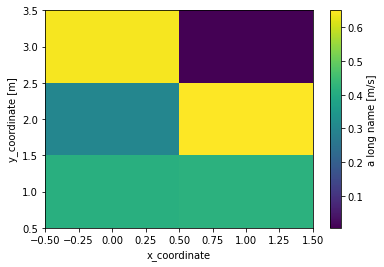

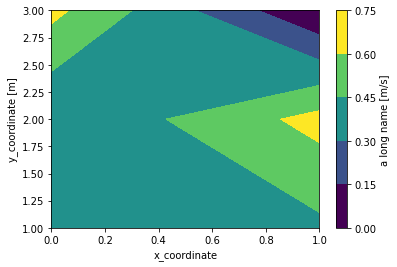

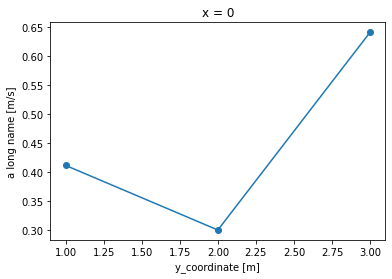

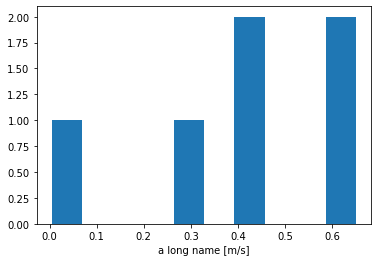

In [35]:
import matplotlib.pyplot as plt
with H5File(h5.hdf_filename, mode='r+') as h5:
    velocity_h5ds = h5['velocity']  # returns h5py dataset
    velocity_xr = h5['velocity'][:]  # slicing returns xarray
    
    # some plotting
    plt.figure()
    h5['velocity'][:].plot()
    plt.figure()
    h5['velocity'][:].plot.contourf()
    plt.figure()
    h5['velocity'][:,0].plot.line(marker='o')
    plt.figure()
    h5['velocity'][:].plot.hist()

Datasets, groups and attributes can be addressed by natural naming:

In [36]:
with H5File(h5.hdf_filename, mode='r+') as h5:
    print(h5.creation_time)
    print(h5.attrs)
    print(h5.velocity)
    h5.create_group('test_group', long_name='a test group')
    print(h5.test_group)
    print('\n')
    h5.dump()

2022-07-28 14:53:45-02:00
__h5rdmtoolbox_version__  0.1.0
__wrcls__                 H5File
creation_time             2022-07-28T14:53:45Z+0200
modification_time         2022-07-28T14:53:46Z+0200
H5Dataset "/velocity"
---------------------
shape:         (3, 2)
long_name:     a long name
standard_name: None
units:         m/s

Dimensions
   [0] /y (3,)
       long_name:     None
       standard_name: y_coordinate
       units:         m
   [1] /x (2,)
       long_name:     None
       standard_name: x_coordinate
       units:         






In [37]:
with H5File(h5.hdf_filename, 'r') as h5:
    print(h5['x'])
    vel = h5['velocity'][:,:]
    print(vel)
    x=h5['x'][:]

H5Dataset "/x"
--------------
shape:         (2,)
long_name:     None
standard_name: x_coordinate
units:         
<xarray.DataArray 'velocity' (y: 3, x: 2)>
array([[0.4117485 , 0.41661407],
       [0.30034225, 0.6505045 ],
       [0.64135884, 0.00478693]])
Coordinates:
  * y        (y) int32 1 2 3
  * x        (x) int32 0 1
Attributes:
    long_name:  a long name
    units:      m/s


In [38]:
vel

<xarray.DataArray 'velocity' (y: 3, x: 2)>
array([[0.4117485 , 0.41661407],
       [0.30034225, 0.6505045 ],
       [0.64135884, 0.00478693]])
Coordinates:
  * y        (y) int32 1 2 3
  * x        (x) int32 0 1
Attributes:
    long_name:  a long name
    units:      m/s